In [1]:
import scipy.stats  as stats
import numpy as np
import os, random
import matplotlib.pyplot as plt
from matplotlib.pylab import imshow, plot, scatter
%matplotlib inline

In [2]:
def boolean_indexing(v):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,np.nan)
    out[mask] = np.concatenate(v)
    return out

def movingaverage(trace, winLen):
    runAvgLength = np.ones(int(winLen))/float(winLen)
    return np.convolve(trace, runAvgLength, mode='same')


def make_template(tau_rise, tau_fall):
    sampling_rate=20000
    t=np.linspace(0.,3.,num=60000)
    template = np.zeros(60000)
    template = (1-np.exp(-t/tau_rise))*np.exp(-t/tau_fall)
    plt.plot(t,template)
    plt.xlim([0, 0.2])
    return template




In [3]:
def make_random_times(back_f, evoked_j, trials, length, Pr):
    all_trials = []
    evoked_mean = np.random.random(1)[0]*0.05+0.91 # make a random time between 0.91 and 0.96 second around which evoked events will occur, can adjust according to cell-to-cell variability
    #print evoked_mean
    for trial_i in range(trials):
        random_times=[]
        random_times.append(random.expovariate(back_f))
        i=0
        while random_times[i]<length:
            random_times.append(random_times[i]+random.expovariate(back_f))
            i+=1
        
        release = np.random.choice([0, 1], p=[1.-Pr, Pr])
        
        if (release == 1):
            random_times.append(np.random.normal(evoked_mean, evoked_j)) # add within cell jitter to evoked time
        
        all_trials.append(random_times)
    markers = list(all_trials)
    for marker_i in range(trials):
        marker_list=[marker_i]*len(markers[marker_i])
        markers[marker_i]=marker_list
    all_trials=boolean_indexing(all_trials) #turn list of lists into numpy array with NaN's to pad out ragged-ness.
    return all_trials

In [4]:
some_randoms=make_random_times(6,0.001,5,3,0.7)

In [5]:
def make_random_plot_timing(back_f,evoked_j,trials,length,Pr):
    all_times = make_random_times(back_f,evoked_j,trials,length,Pr)
    event_hist= np.histogram(all_times, range = [0,length], bins = np.linspace(0.0,length,length*1000)) #1 ms bins
    slide = movingaverage(event_hist[0],10) # 10 point window
    slideToRate = slide/trials*1000
    markers = list(all_times)
    for marker_i in range(trials):
        marker_list=[marker_i+1]*len(markers[marker_i])
        markers[marker_i]=marker_list
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    # the scatter plot:
    for i in range(trials):
        axScatter.scatter(all_times[i], markers[i], marker = "|", color = "black")
    axHistx.plot(event_hist[1][0:len(event_hist[1])-1],slideToRate)
    axScatter.set_xlim([0, length])
    axScatter.set_ylim([0,trials+1])
    axScatter.set_xlabel('time (s)')
    axHistx.set_ylabel('event rate')
    
    peak_time = event_hist[1][np.argmax(slide)]
    print 'histogram peak at '+str(peak_time)
    avg_back = np.mean(slideToRate[10:900])
    std_back = np.std(slideToRate[10:900])
    peak = np.max(slideToRate[910:960])
    print 'avg back events ' + str(avg_back)+' +/- '+str(std_back)+', peak was '+ str(peak) 
    something_happened = 0
    if(peak>avg_back+3*std_back):
        #print "something happened"
        something_happened = 1
    measures = np.array([avg_back, std_back, peak, something_happened])

Below, I simulate 20 sweeps with an average background rate of 6 Hz and an evoked event with a 0.7 probability of release and 5 ms jitter. A distinct peak is obvious in the all events histogram.

histogram peak at 0.95531843948
avg back events 6.6404494382 +/- 6.1993968373, peak was 70.0


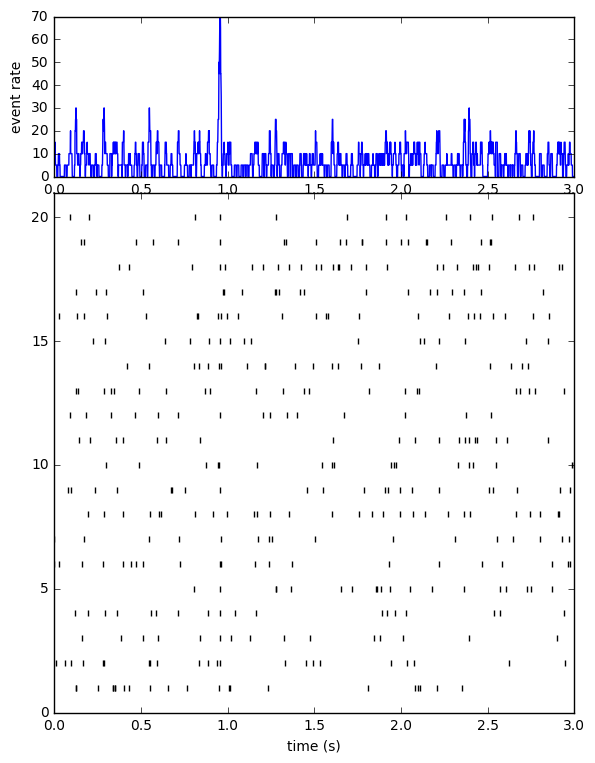

In [6]:
make_random_plot_timing(6,.005,20,3,0.7)

However, if you try to make the same call after only 5 sweeps of data, the evoked connection cannot be resolved. The peaks in this histogram are due to random occurances of background activity within a small time window.

histogram peak at 1.51950650217
avg back events 5.03370786517 +/- 10.1144567114, peak was 60.0


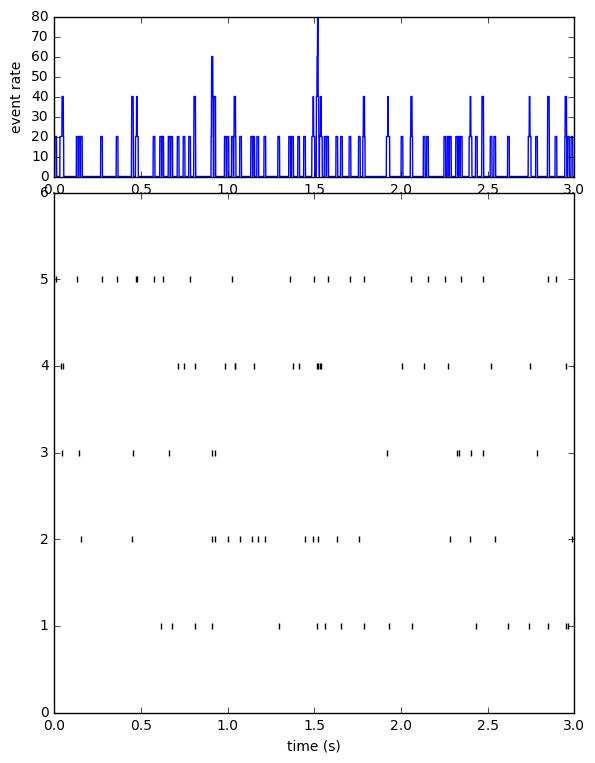

In [9]:
make_random_plot_timing(6,.005,5,3,0.7)

In [10]:
def multiple_cells(n_cells, back_f, evoked_j, trials, length, Pr):
    n_cells_output = np.array([0,0,0,0])
    all_pos_times=[]
    for i in range(n_cells):
        all_times = make_random_times(back_f,evoked_j,trials,length,Pr)
        event_hist= np.histogram(all_times, range = [0,length], bins = np.linspace(0.0,length,length*1000)) #1 ms bins
        slide = movingaverage(event_hist[0],10) # 10 point window
        slideToRate = slide/trials*1000
        avg_back = np.mean(slideToRate[10:900])
        std_back = np.std(slideToRate[10:900])
        peak = np.max(slideToRate[910:960])
        something_happened = 0
        if(peak>avg_back+3*std_back):
            #print "something happened"
            something_happened = 1
            all_pos_times.append(all_times)
        i_output = np.array([avg_back,std_back,peak,something_happened])
        n_cells_output = np.row_stack((n_cells_output, i_output))
    #all_pos_times=np.array(all_pos_times)
    total_detects=np.sum(n_cells_output[:,3])
    perc_detects=total_detects/n_cells*100
    print str(perc_detects)+'% of cells detected'
    
    return [n_cells_output,all_pos_times]

So how many sweeps do you need? Below we'll run 1000 simulations for a variable number of sweeps. We'll use a somewhat naive criteria for determining if there's a connection there - if the peak response in the 50 ms window in which we expect the evoked events to occur is >3 standard deviations above the average background rate.

In [11]:
mylist=[5,10,15,20,30,40,50]
for sweeps in mylist:
    multiple_cells(1000,6,0.005,sweeps,3,0.7)

89.7% of cells detected
99.2% of cells detected
99.9% of cells detected
100.0% of cells detected
100.0% of cells detected
100.0% of cells detected
100.0% of cells detected


Hey! Not bad, with 20 sweeps this unreliable, jittery event stands out from a somewhat high frequency of background events everytime. Now, what if we apply the same criteria to a case where there's no evoked events. We can repeat the multiple cell simulation, but now set Pr =0.

In [12]:
mylist=[5,10,15,20,30,40,50]
for sweeps in mylist:
    multiple_cells(1000,6,0.005,sweeps,3,0)

20.8% of cells detected
17.2% of cells detected
13.4% of cells detected
12.0% of cells detected
11.4% of cells detected
11.8% of cells detected
11.0% of cells detected


Shit! What a mess. With 6 Hz background activity, there's a reasonably high probability that events align in our search window to give a false positive. And worse, increasing the  number of sweeps doesn't help much. Maybe I should've picked a higher criteria for the presence of connections. Let's see what the distribution of the peak events looks like for the connection case and the no connection case.

In [13]:
def compare_to_0(n_cells, back_f, evoked_j, trials, length, Pr):
    noevoked_array=multiple_cells(n_cells,back_f,evoked_j,trials,length,0)
    evoked_array=multiple_cells(n_cells,back_f,evoked_j,trials,length,Pr)
    summary_noev=noevoked_array[0]
    summary_ev=evoked_array[0]
    ev_hist=np.histogram(summary_ev[1:,2], density=False)
    noev_hist=np.histogram(summary_noev[1:,2], density=False)
    myplot=plt.figure()
    plt.hist(summary_ev[1:,2], alpha=0.5)
    plt.hist(summary_noev[1:,2], alpha=0.5)
    plt.xlabel('peak response')
    plt.ylabel('# of occurances')
    return [noev_hist,ev_hist]

16.1% of cells detected
99.2% of cells detected


[(array([ 32, 299, 431,   0, 189,  43,   0,   5,   0,   1], dtype=int64),
  array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.])),
 (array([  6, 100, 185, 163, 307, 146,  64,  23,   5,   1], dtype=int64),
  array([  20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,  100.,
          110.,  120.]))]

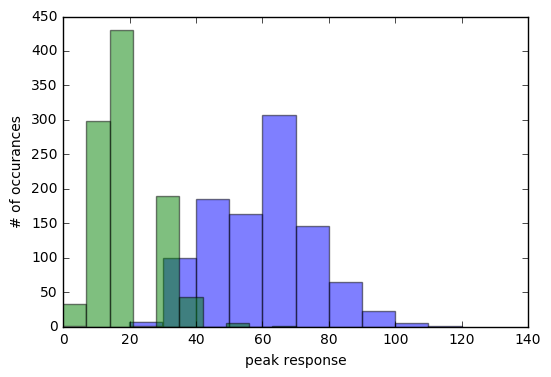

In [14]:
compare_to_0(1000,6,.005,10,3,.7)

So, with 10 sweeps, there's overlap in the histograms meaning no criteria will correctly detect all connections and reject all no connection simulations. But what threshold will do the best?

In [15]:
def plotROC(n_cells, back_f, evoked_j, trials, length, Pr):
    noevoked_array=multiple_cells(n_cells,back_f,evoked_j,trials,length,0)
    evoked_array=multiple_cells(n_cells,back_f,evoked_j,trials,length,Pr)
    summary_noev=noevoked_array[0]
    summary_ev=evoked_array[0]
    evoked_peaks=summary_ev[1:,2]
    noevoked_peaks=summary_noev[1:,2]
    xthresh=[]
    hit_list=[]
    false_list=[]
    error_list=[]
    for threshold in range(int(np.max(evoked_peaks+1))):
        hits = float(np.count_nonzero(threshold <= evoked_peaks))
        false_alarms = float(np.count_nonzero(threshold <= noevoked_peaks))
        error=(n_cells-hits)+false_alarms
        xthresh.append(threshold)
        hit_list.append(hits/float(n_cells))
        false_list.append(false_alarms/float(n_cells))
        error_list.append(error/(2*n_cells))
    min_error, min_error_i = min((min_error, min_error_i) for (min_error_i, min_error) in enumerate(error_list))
    #print xthresh, hit_list, false_list,error_list
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.hist(evoked_peaks, alpha=0.5)
    ax1.hist(noevoked_peaks, alpha=0.5)
    ax1.set_xlabel('peak response')
    ax1.set_ylabel('# of occurances')
    ax1.axvline(x=xthresh[min_error_i], color = 'black')
    ax2.plot(false_list,hit_list)
    ax2.set_ylabel('hits')
    ax2.set_xlabel('false alarms')
    ax2.set_xlim([-0.01,1])
    ax2.set_ylim([0,1.01])
    print 'minimum error of '+ str(min_error)+' at threshold = '+str(xthresh[min_error_i])

14.4% of cells detected
98.8% of cells detected
minimum error of 0.0305 at threshold = 31


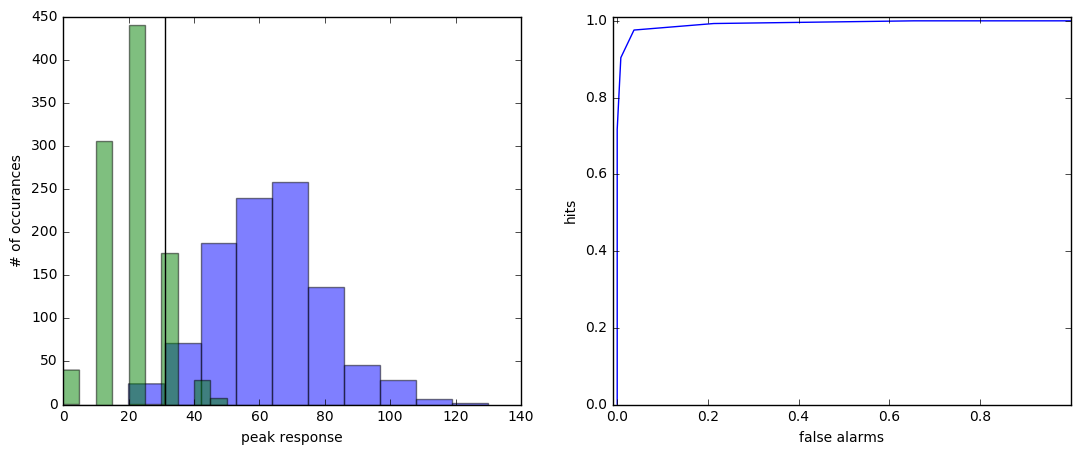

In [16]:
plotROC(1000,6,.005,10,3,0.7)

12.9% of cells detected
95.5% of cells detected
minimum error of 0.0795 at threshold = 41


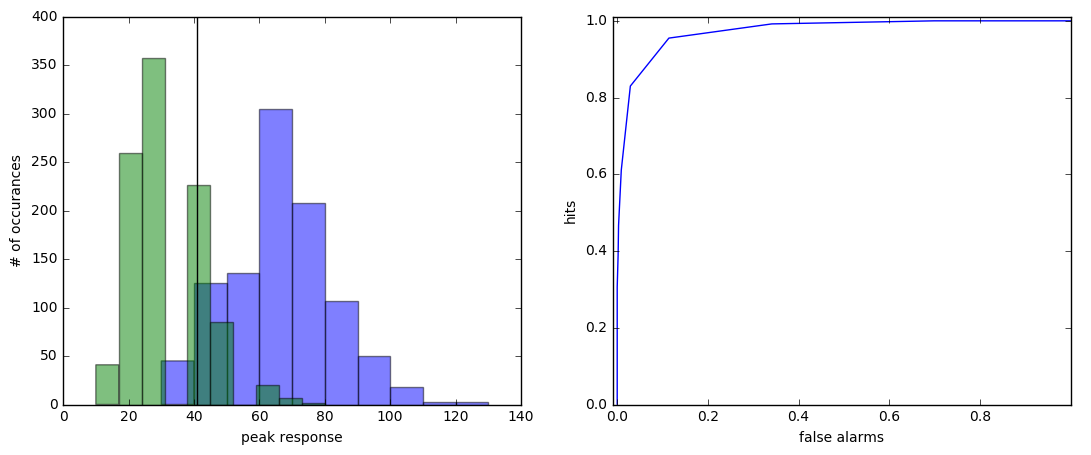

In [17]:
plotROC(1000,12,.005,10,3,0.7)

10.7% of cells detected
81.9% of cells detected
minimum error of 0.1335 at threshold = 26


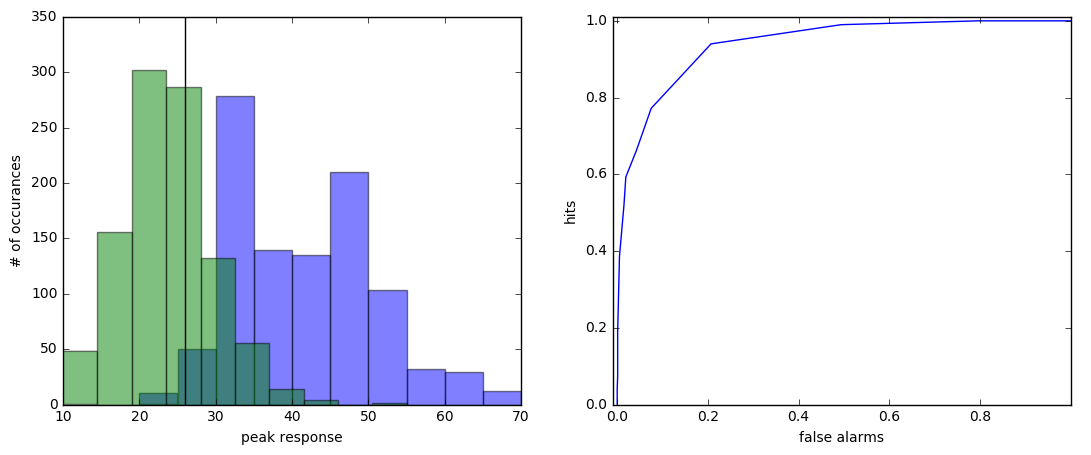

In [18]:
plotROC(1000,10,.01,20,3,0.5)

13.6% of cells detected
95.7% of cells detected
minimum error of 0.0705 at threshold = 21


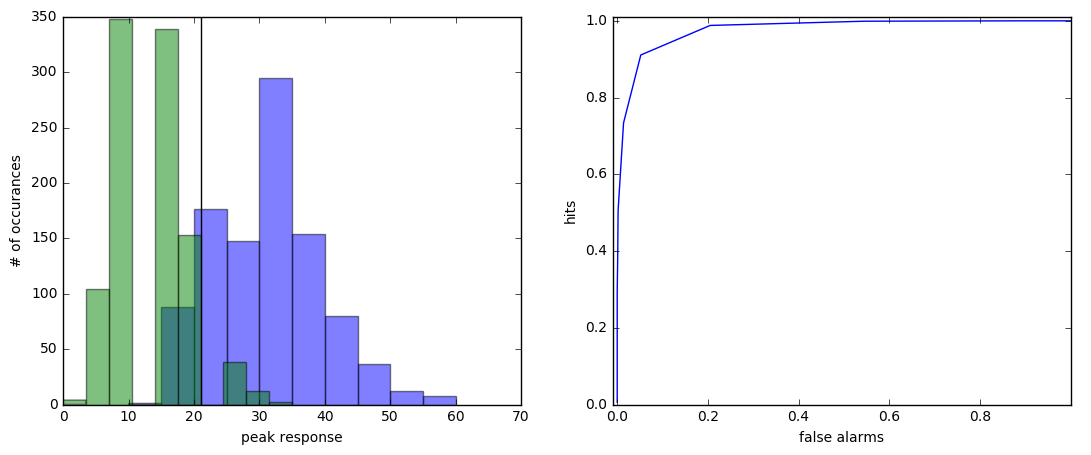

In [19]:
plotROC(1000,5,.01,20,3,0.5)

19.8% of cells detected
96.8% of cells detected
minimum error of 0.0455 at threshold = 21


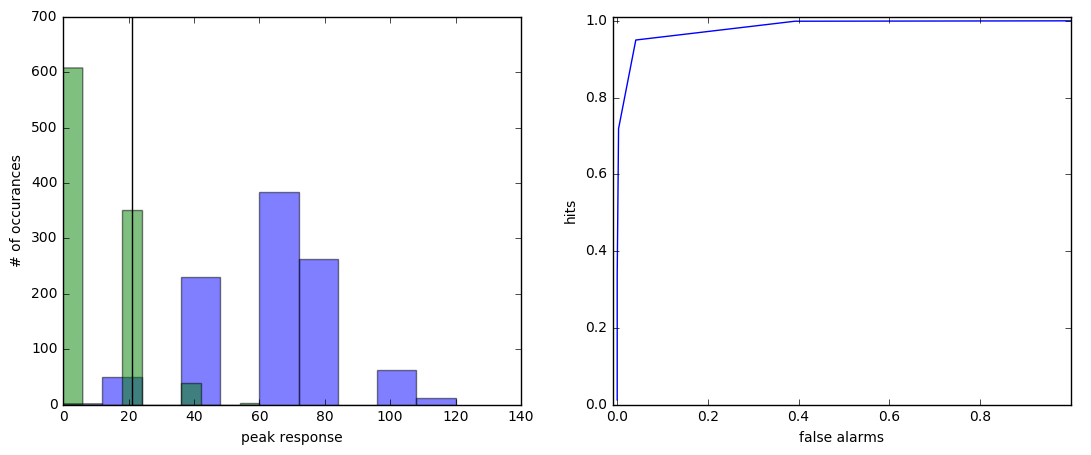

In [20]:
plotROC(1000,2,.005,5,3,0.7)

16.1% of cells detected
100.0% of cells detected
minimum error of 0.007 at threshold = 21


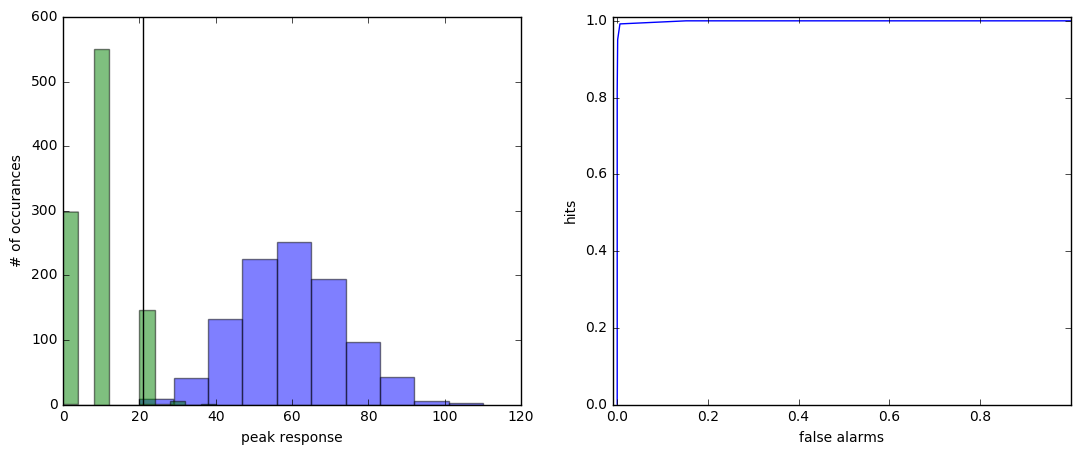

In [21]:
plotROC(1000,2,.005,10,3,0.7)

13.0% of cells detected
100.0% of cells detected
minimum error of 0.0005 at threshold = 21


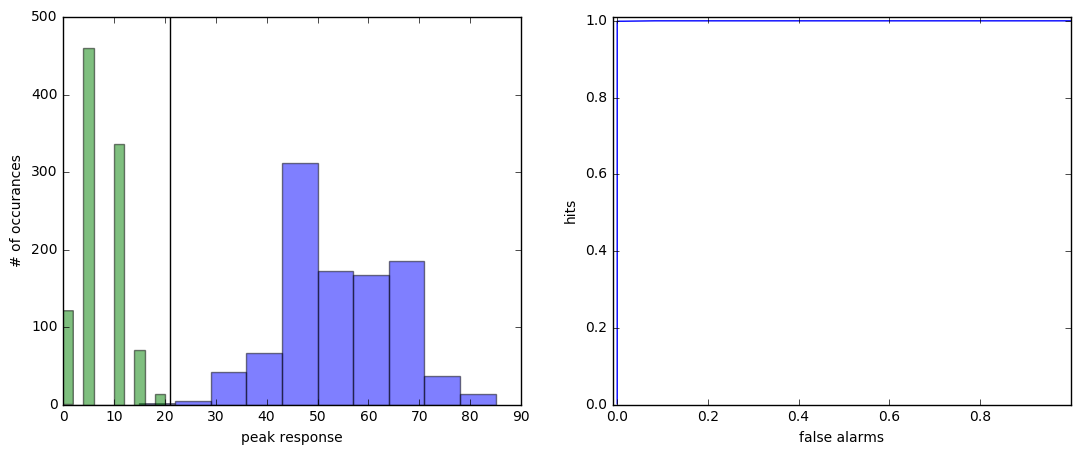

In [22]:
plotROC(1000,2,.005,20,3,0.7)

21.6% of cells detected
90.2% of cells detected
minimum error of 0.1285 at threshold = 41
18.4% of cells detected
98.5% of cells detected
minimum error of 0.042 at threshold = 31
12.9% of cells detected
100.0% of cells detected
minimum error of 0.0095 at threshold = 34
12.5% of cells detected
100.0% of cells detected
minimum error of 0.0095 at threshold = 31
12.6% of cells detected
100.0% of cells detected
minimum error of 0.0005 at threshold = 31


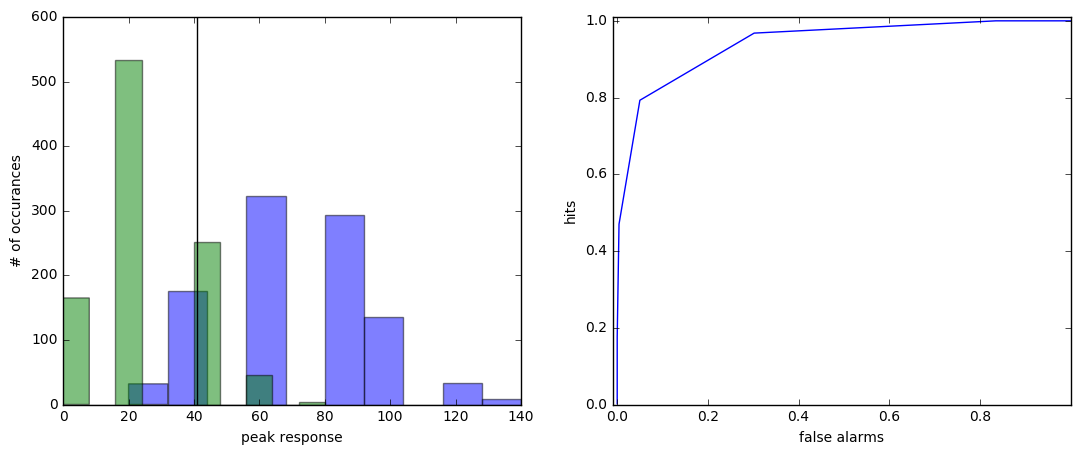

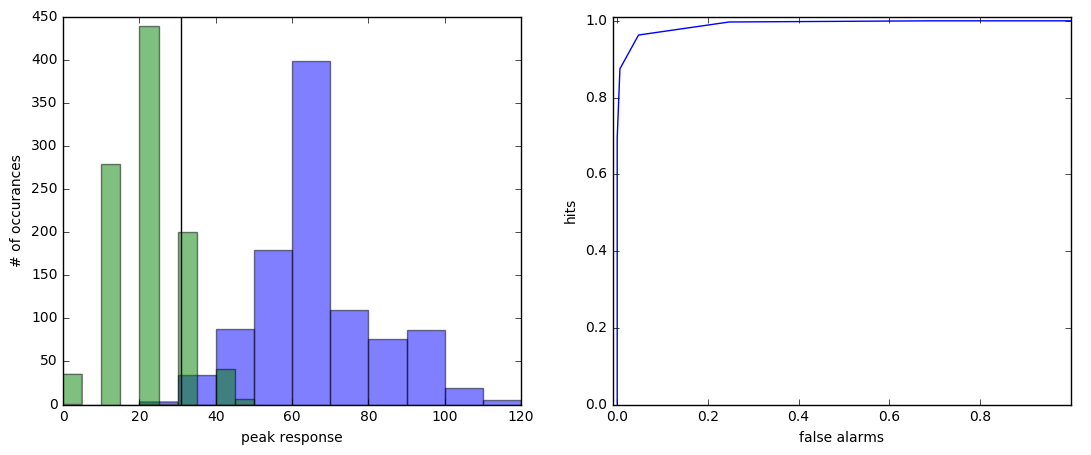

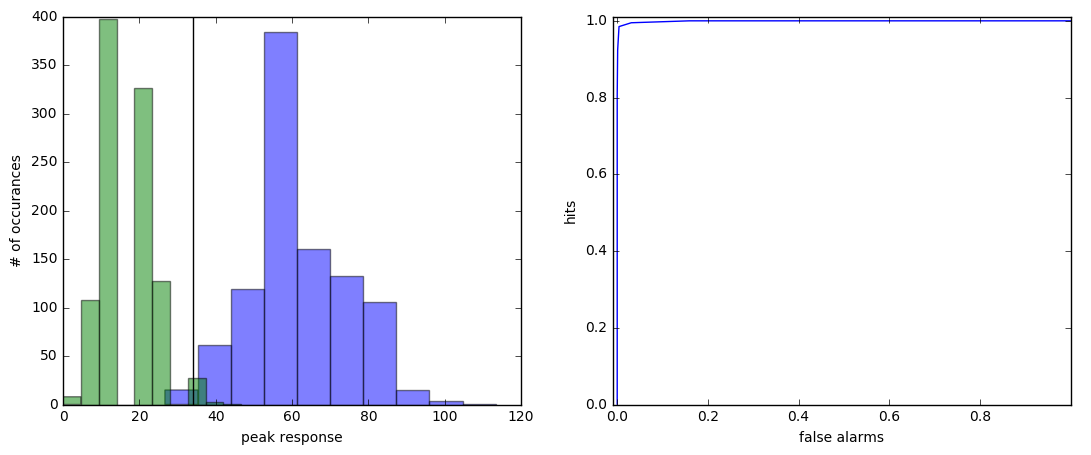

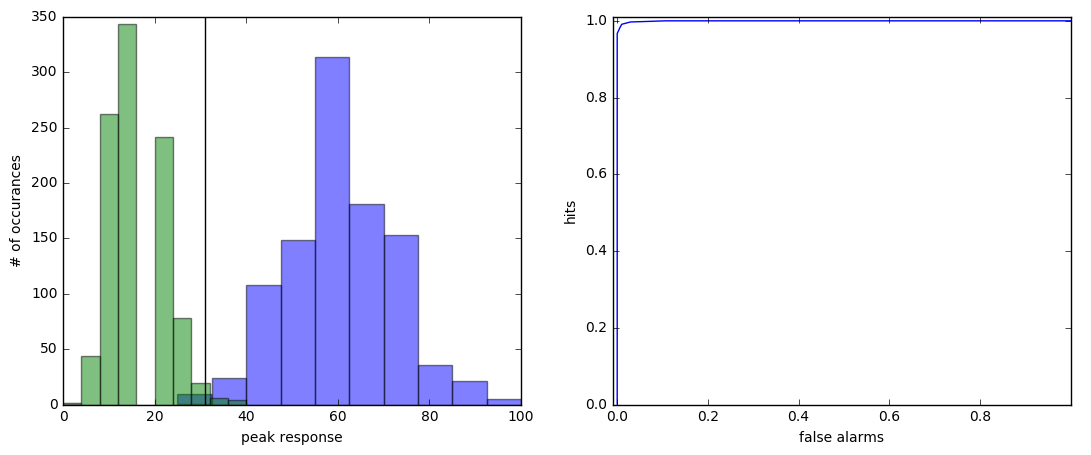

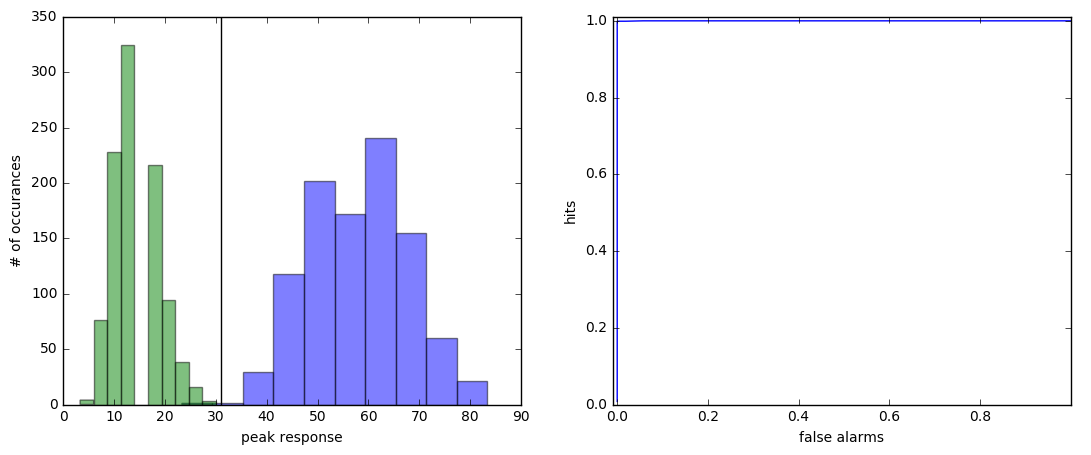

In [23]:
shortlist=[5,10,15,20,30]
for sweeps in shortlist:
    plotROC(1000,6,.005,sweeps,3,0.7)

20.8% of cells detected
54.1% of cells detected
minimum error of 0.3035 at threshold = 21
19.1% of cells detected
64.1% of cells detected
minimum error of 0.2385 at threshold = 21
13.0% of cells detected
76.6% of cells detected
minimum error of 0.172 at threshold = 21
13.7% of cells detected
85.6% of cells detected
minimum error of 0.1275 at threshold = 21
10.7% of cells detected
93.2% of cells detected
minimum error of 0.075 at threshold = 21


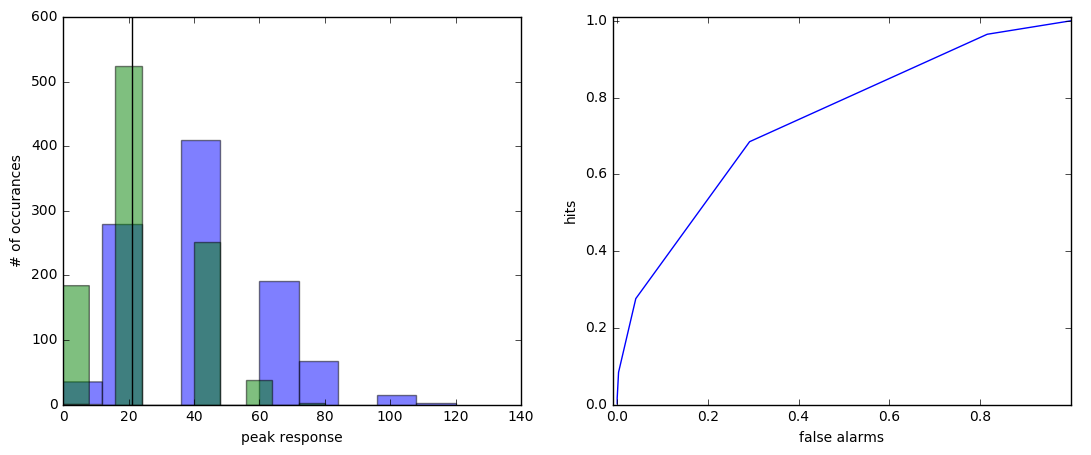

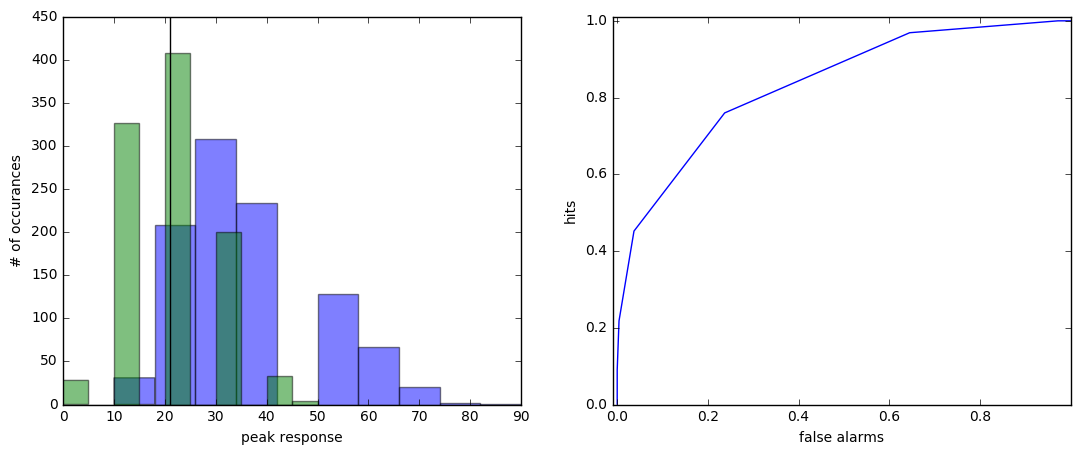

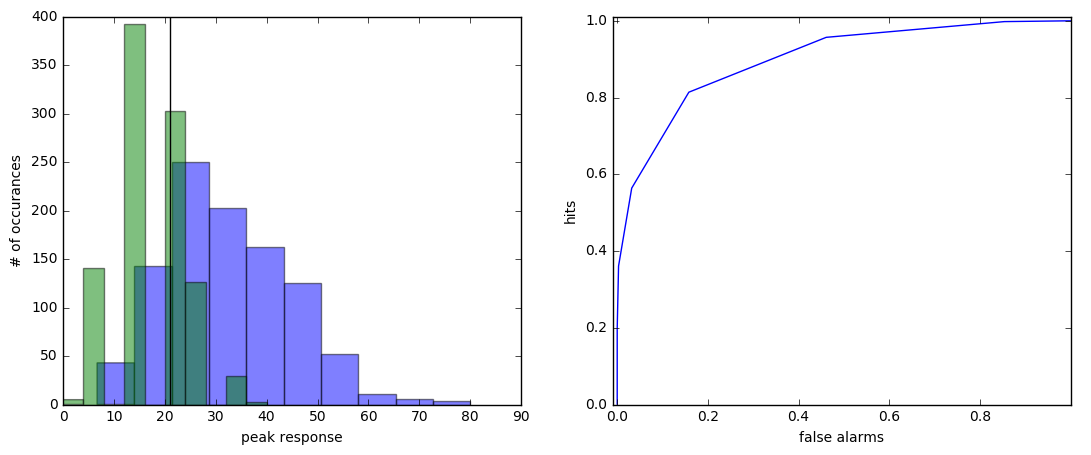

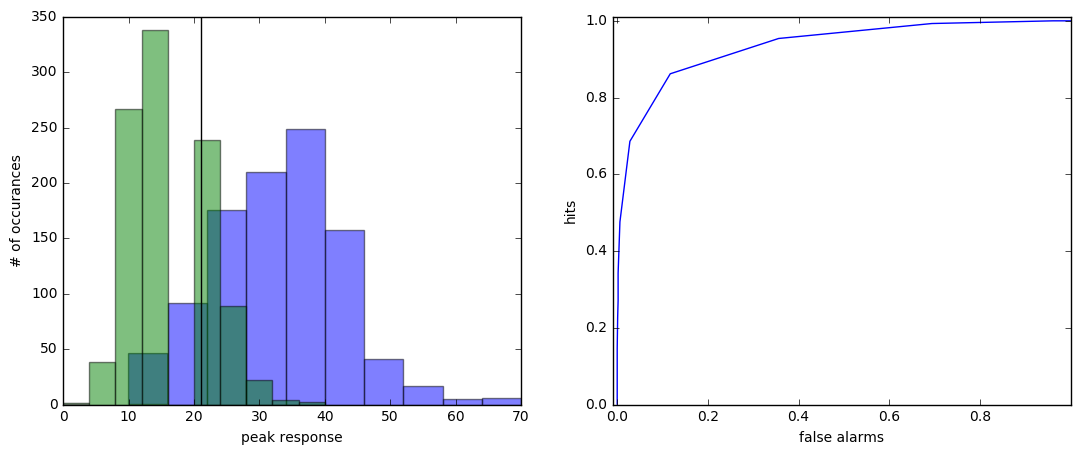

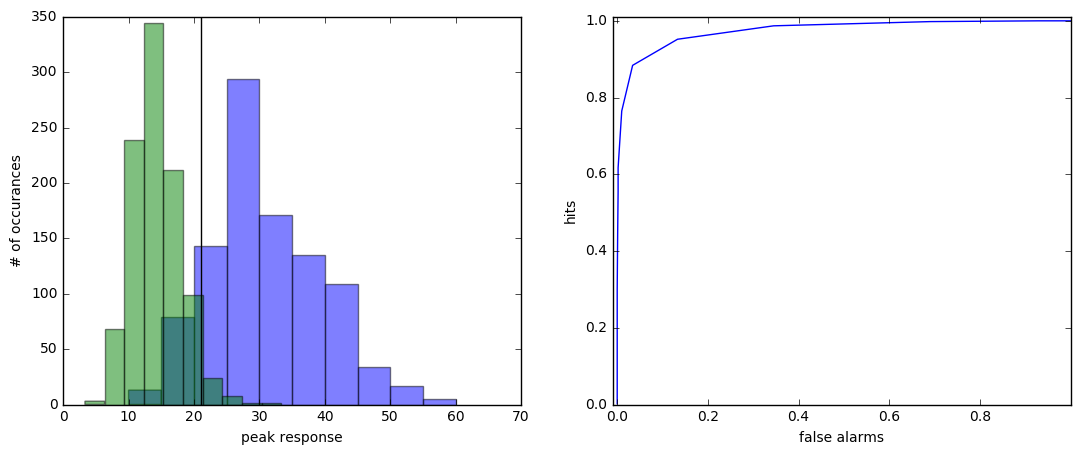

In [24]:
shortlist=[5,10,15,20,30]
for sweeps in shortlist:
    plotROC(1000,6,.005,sweeps,3,0.3)

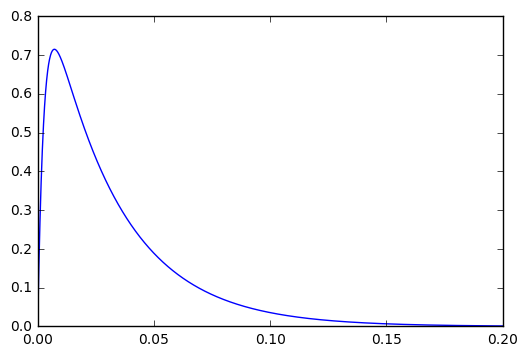

In [25]:
psp_template = make_template(.003,.030)

In [27]:
def times_to_sweep(random_times, template):
    length = 3
    sampling = 20000
    for sweep_i in range(len(random_times)):
        events=len(random_times[sweep_i])
        random_psps=np.zeros(length*sampling)
        t = np.linspace(0.,length,num=length*sampling)
        for i in range(events):
            random_psp_i=np.zeros(length*sampling)
            if np.isnan(random_times[sweep_i,i]):
                break
            random_point=int(random_times[sweep_i,i]*sampling)
            random_psp_i[random_point:]=template[:-random_point]
            random_psps=random_psps+random_psp_i
        plt.plot(t,random_psps)
    #plt.xlim([0.5, 1.5])

In [28]:
a=0.6
n_samples=int(60000)
noise=w=np.random.normal(size=n_samples)

for p in range(n_samples):
    noise[p]=a*noise[p-1]+w[p]

plt.plot(t,noise)
plt.xlim([0.9,1.1])

NameError: name 't' is not defined

In [29]:
alphas=np.array([.666,-.333])
betas = np.array([0.])
n_samples=int(60000)

ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n_samples)



plt.plot(t,ar2)
plt.xlim([0.9,1.1])

NameError: name 'smt' is not defined

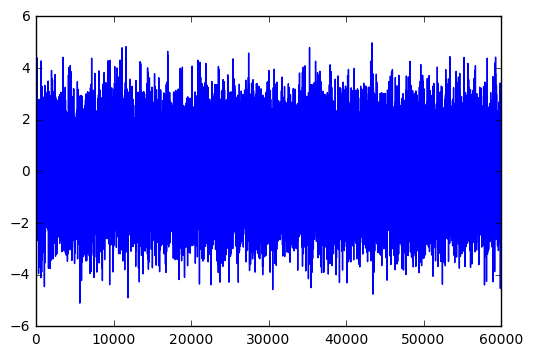

In [30]:
noise=np.array(noise)
plt.plot(noise)

In [31]:
test=make_random_times(3,.01,1,3,1)

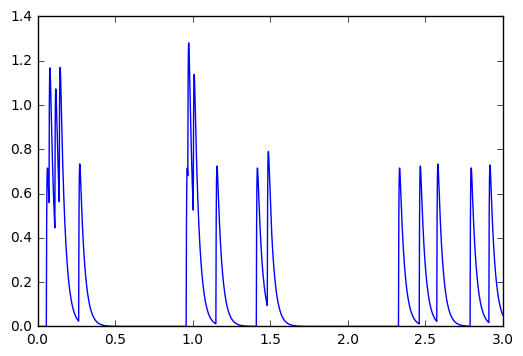

In [32]:
times_to_sweep(test,psp_template)

In [33]:
def times_to_sweep_withvar(random_times, template):
    length = 3
    sampling = 20000
    for sweep_i in range(len(random_times)):
        events=len(random_times[sweep_i])
        random_psps=np.zeros(length*sampling)
        t = np.linspace(0.,length,num=length*sampling)
        for i in range(events):
            random_psp_i=np.zeros(length*sampling)
            if np.isnan(random_times[sweep_i,i]):
                break
            random_point=int(random_times[sweep_i,i]*sampling)
            random_psp_i[random_point:]=template[:-random_point]*np.random.normal(1,0.2,1)
            random_psps=random_psps+random_psp_i
        plt.plot(t,random_psps)
        return random_psps
    #plt.xlim([0.5, 1.5])

In [34]:
t=np.linspace(0.,3.,num=60000)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.8, 1.1)

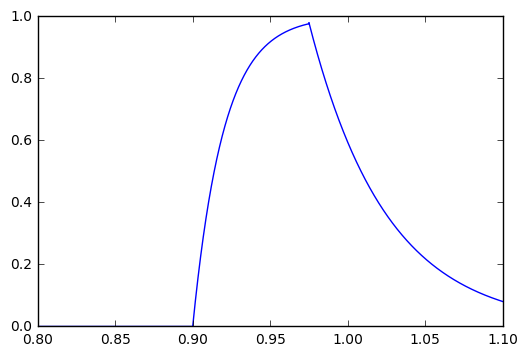

In [35]:
length = 3.
sampling = 20000
t = np.linspace(0.,length,num=length*sampling)
tstim=np.linspace(0.,0.075,num=0.075*sampling)
toff=np.linspace(0.,1.,num=(sampling*(1)))
direct=np.zeros(length*sampling)
direct[0.9*sampling:0.975*sampling] = 1-np.exp((-tstim)/0.02)
direct[0.975*sampling:1.975*sampling]=0.98*np.exp((-toff)/0.05)
plt.plot(t,direct)
plt.xlim([0.8, 1.1])

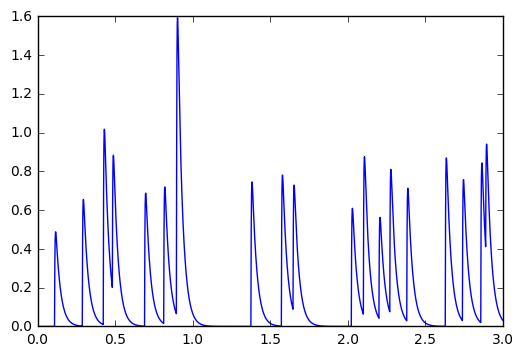

In [36]:
test_psps=times_to_sweep_withvar(make_random_times(5,.01,1,3,1),psp_template)

(0.5, 1.5)

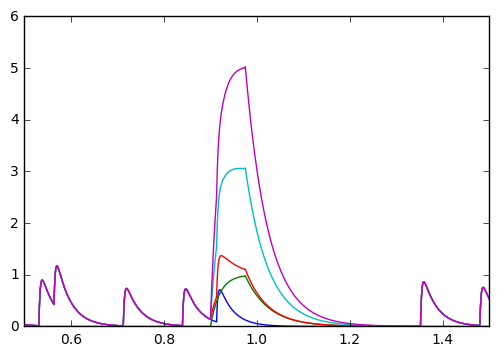

In [141]:
plt.plot(t,test_psps)
plt.plot(t,direct)
plt.plot(t,test_psps+1*direct)
plt.plot(t,test_psps+3*direct)
plt.plot(t,test_psps+5*direct)
plt.xlim([0.5, 1.5])

In [82]:
np.shape(test_psps)

(60000L,)

In [37]:
def make_random_times_plot_sweeps(back_f, evoked_j, trials, length, Pr, template):
    all_times = make_random_times(back_f,evoked_j,trials,length,Pr)
    all_sweeps=np.zeros((length*20000, trials))
    for trial_i in range(trials):
        trial_i_sweep = times_to_sweep_withvar(all_times[:,trial_i], template)
        all_sweeps[:,trial_i]=trial_i_sweep
    return all_sweeps

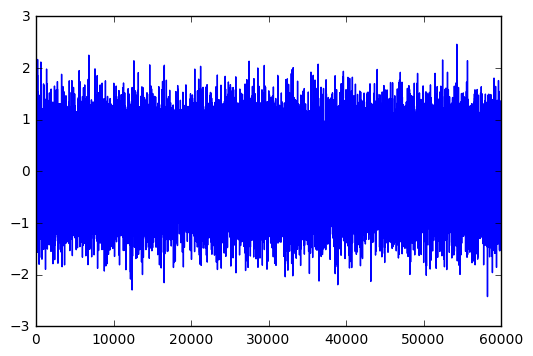

In [38]:
T = 60000 #samples: 3 seconds at 20 kHz

white_noise = np.random.normal(0, 0.5, T)

ar_noise = np.zeros(T)
ar_noise[0] = white_noise[0]

p_sigma = 0.1 #standard deviation of model parameters

#fill autoregressive noise
for i in range(T-1):
    p = np.array([0.2, 0.3]) #could be altered
    ar_noise[i+1] = np.sum(p*ar_noise[i]) + white_noise[i+1]

plt.plot(ar_noise)

In [43]:
def make_random_template(tau_rise, tau_fall):
    sampling_rate=20000
    t=np.linspace(0.,3.,num=60000)
    template = np.zeros(60000)
    tau_rise_r=np.random.normal(tau_rise, .001)
    tau_fall_r=np.random.normal(tau_fall, .01)
    scale=np.random.normal(1,0.5)
    template = scale*(1-np.exp(-t/tau_rise_r))*np.exp(-t/tau_fall_r)
    #plt.plot(t,template)
    #plt.xlim([0, 0.2])
    return template

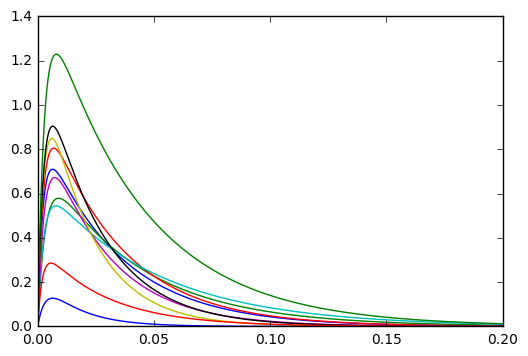

In [42]:
for i in range(10):
    make_random_template(.003,.03)

In [44]:
def times_to_sweep_rand_temp(random_times, tau_rise, tau_fall):
    length = 3
    sampling = 20000
    random_psps=np.zeros(length*sampling)
    for sweep_i in range(len(random_times)):
        events=len(random_times[sweep_i])    
        t = np.linspace(0.,length,num=length*sampling)
        for event_i in range(events):
            random_psp_i=np.zeros(length*sampling)
            if np.isnan(random_times[sweep_i,event_i]):
                break
            random_point=int(random_times[sweep_i,event_i]*sampling)
            template_i=make_random_template(tau_rise, tau_fall)
            random_psp_i[random_point:]=template_i[:-random_point]
            random_psps=random_psps+random_psp_i
        plt.plot(t,random_psps)
    return random_psps
    #plt.xlim([0.5, 1.5])

In [45]:
test_times=make_random_times(5,.01,1,3,1)
print np.shape(test_times)

(1L, 14L)


In [125]:
test_times[0]

array([ 0.07722207,  0.39336251,  0.56232673,  0.64072893,  0.71710284,
        0.82630369,  0.86392457,  0.97168635,  1.0099732 ,  1.0143506 ,
        1.27915903,  1.39857281,  1.74049568,  1.81216313,  1.99295461,
        2.29908773,  2.31142998,  2.32315009,  2.34404702,  2.58688008,
        2.83426387,  3.15561536,  0.92274936])

array([ 0.        ,  0.        ,  0.        , ...,  0.82511555,
        0.82530607,  0.82548168])

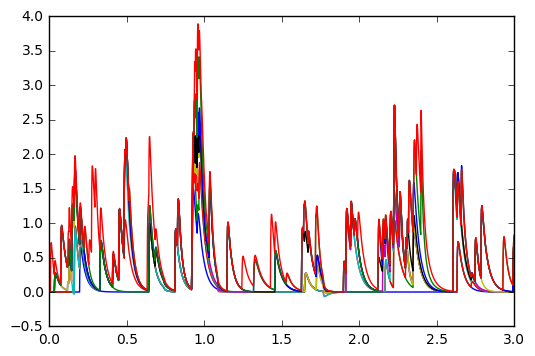

In [46]:
times_to_sweep_rand_temp(make_random_times(3,.01,10,3,0.8),.003,.03)

array([ 0.        ,  0.        ,  0.        , ...,  0.43230558,
        0.431568  ,  0.43083204])

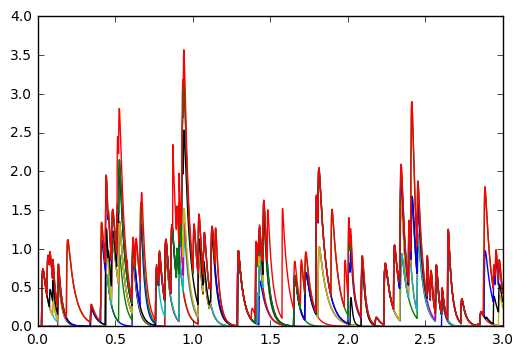

In [47]:
times_to_sweep_rand_temp(make_random_times(3,.01,10,3,0.8),.003,.03)

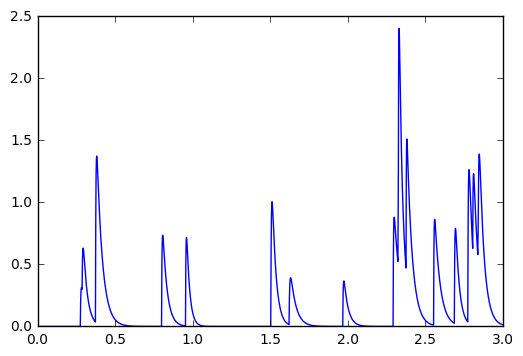

In [48]:
thissweep=times_to_sweep_rand_temp(make_random_times(5,.01,1,3,1),.003,.03)

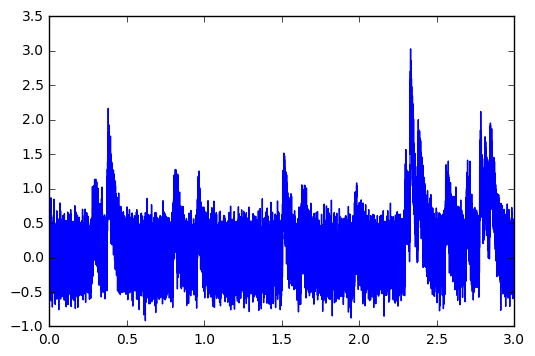

In [52]:


plt.plot(t,thissweep+.4*ar_noise)
##plt.xlim([0., 1.5])